In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from umap import UMAP, plot

# random varaible values and parameter values
df = pd.read_csv('azdiabetes.csv')
X = df[['npreg', 'bp', 'bmi', 'ped', 'age']]
X = (X - X.mean()) / X.std()  # centering and scaling
X['intercept'] = 1
X = X.values
X = np.concatenate((X[:, -1:], X[:, :-1]), axis=1)
y = df['diabetes'].replace({'Yes': 1, 'No': 0})

# multiple chains of initial values of beta and z
mean_beta = np.zeros(6)
cov_beta = np.diag([16, 4, 4, 4, 4, 4])
beta =  np.random.multivariate_normal(mean_beta, cov_beta, 6)
z = np.random.choice([0, 1], size=(6, X.shape[1]))
z[:,0] = 1

/Users/cherylshi/UROP/PoP_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cherylshi/UROP/PoP_venv/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/cherylshi/UROP/PoP_venv/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/Users/cherylshi/UROP/PoP_venv/lib/python3.11/site-p

In [2]:
from sampler import MetropolisHastingsSampler

cov_beta = np.array([16, 4, 4, 4, 4, 4])

beta_MH, z_MH = MetropolisHastingsSampler(y, X, z[0], beta[0], mean_beta, cov_beta).run_sampler()
beta_MH = np.expand_dims(beta_MH, axis=0)
z_MH = np.expand_dims(z_MH, axis=0)


for r in range(1,6):
    target_beta, target_z = MetropolisHastingsSampler(y, X, z[r], beta[r], mean_beta, cov_beta).run_sampler()
    target_beta = np.expand_dims(target_beta, axis=0)
    target_z = np.expand_dims(target_z, axis=0)
    beta_MH = np.concatenate((beta_MH, target_beta), axis=0)
    z_MH = np.concatenate((z_MH, target_z), axis=0)

/Users/cherylshi/UROP/PoP_venv/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


<xarray.Dataset> Size: 192B
Dimensions:    (parameter: 6)
Coordinates:
  * parameter  (parameter) <U6 144B 'beta_0' 'beta_1' ... 'beta_4' 'beta_5'
Data variables:
    beta       (parameter) float64 48B 8.981 135.8 61.39 56.56 21.05 38.84


/Users/cherylshi/UROP/PoP_venv/lib/python3.11/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)
/Users/cherylshi/UROP/PoP_venv/lib/python3.11/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)
/Users/cherylshi/UROP/PoP_venv/lib/python3.11/site-packa

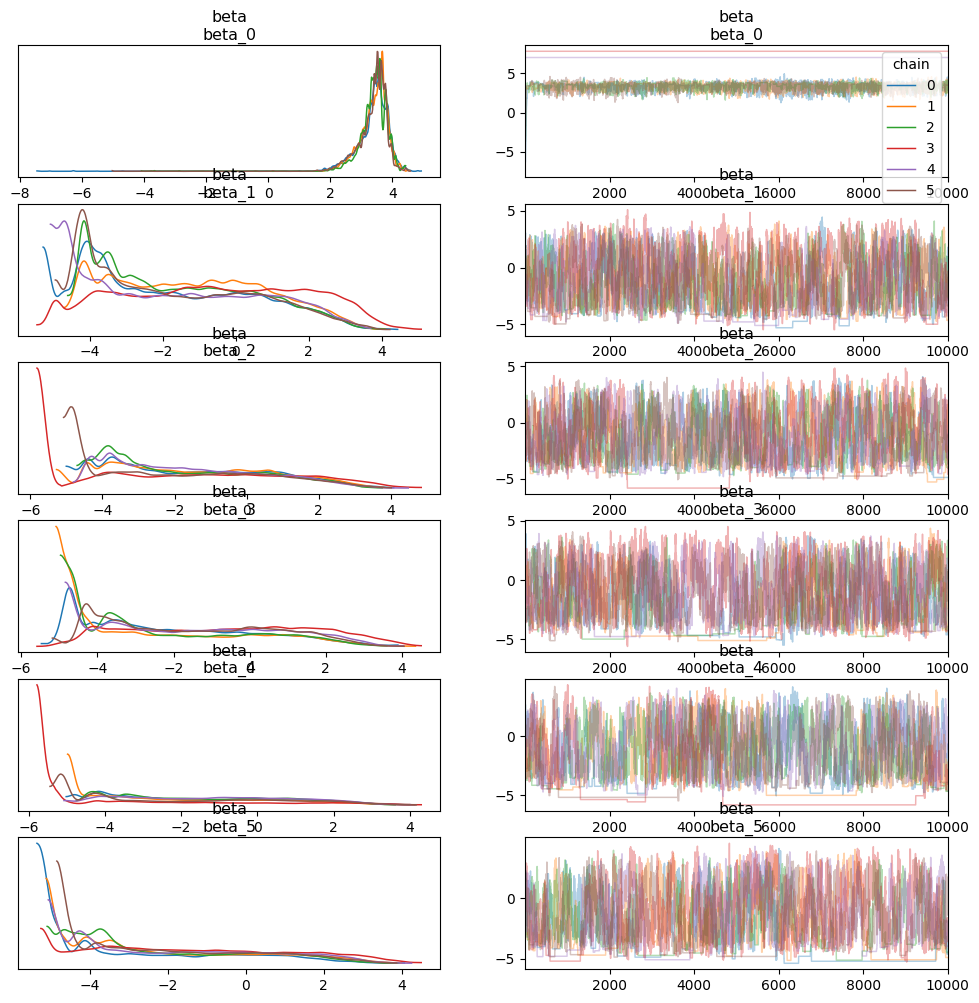

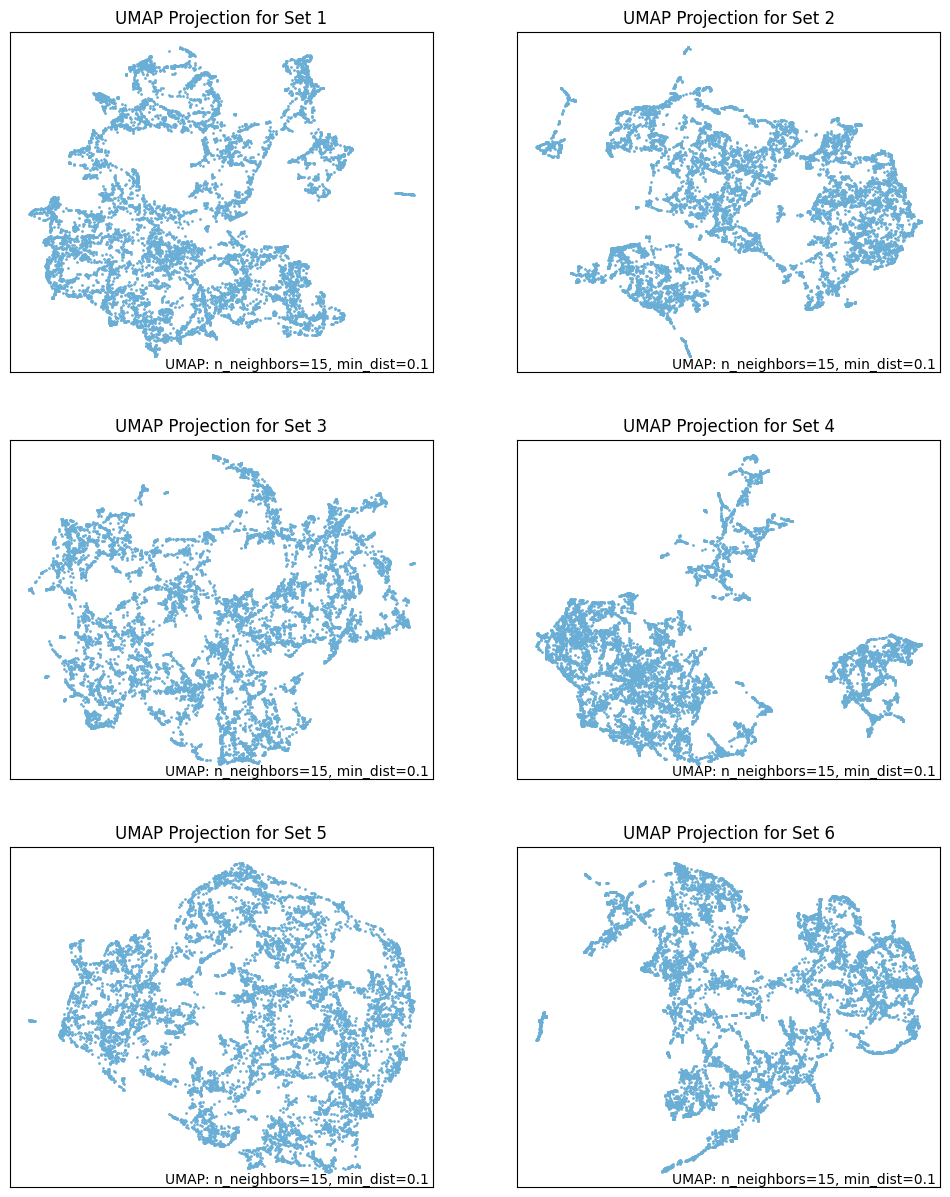

In [3]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
import umap.plot

# trace plot of MH
coords = {
    "chain": np.arange(1,7),
    "draw": np.arange(1,10001),
    "parameter": [f"beta_{i}" for i in range(6)]
}
dims = {"beta": ["chain", "draw", "parameter"]}

# Wrapping data in a dictionary with the variable name
MH_data_dict = {"beta": beta_MH}
betadata_MH = az.convert_to_dataset(MH_data_dict,
                                    coords=coords, dims=dims)
az.plot_trace(betadata_MH, combined=False, compact=False, legend=True)

# Create a 3x2 grid for UMAP plots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Apply UMAP and plot in subplots without a loop for plotting
for r in range(6):
    betadata_PG_r = az.convert_to_dataset(beta_MH[r].T)
    df = pd.DataFrame(beta_MH[r], columns=['beta0', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5'])
    
    # Fit UMAP
    map = UMAP().fit(df)

    # Determine the correct subplot position
    ax = axes[r // 2, r % 2]
    
    # Use plot.points to plot directly to the subplot
    umap.plot.points(map, ax=ax)  # Assign UMAP points to the specific subplot
    ax.set_title(f'UMAP Projection for Set {r + 1}')

# Adjust layout

plt.show()


In [4]:
from sampler import PolyaGamma

cov_beta = np.diag([16, 4, 4, 4, 4, 4])

beta_PG, z_PG = PolyaGamma(y, X, z[0], beta[0], mean_beta, cov_beta).run_sampler()
beta_PG = np.expand_dims(beta_PG, axis=0)
z_PG = np.expand_dims(z_PG, axis=0)

for r in range(1,6):
    target_beta, target_z = PolyaGamma(y, X, z[r], beta[r], mean_beta, cov_beta).run_sampler()
    target_beta = np.expand_dims(target_beta, axis=0)
    target_z = np.expand_dims(target_z, axis=0)
    beta_PG = np.concatenate((beta_PG, target_beta), axis=0)
    z_PG = np.concatenate((z_PG, target_z), axis=0)

<xarray.Dataset> Size: 192B
Dimensions:    (parameter: 6)
Coordinates:
  * parameter  (parameter) <U6 144B 'beta_0' 'beta_1' ... 'beta_4' 'beta_5'
Data variables:
    beta       (parameter) float64 48B 3.339e+04 4.382e+04 ... 4.166e+04


/Users/cherylshi/UROP/PoP_venv/lib/python3.11/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)
/Users/cherylshi/UROP/PoP_venv/lib/python3.11/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)
/Users/cherylshi/UROP/PoP_venv/lib/python3.11/site-packa

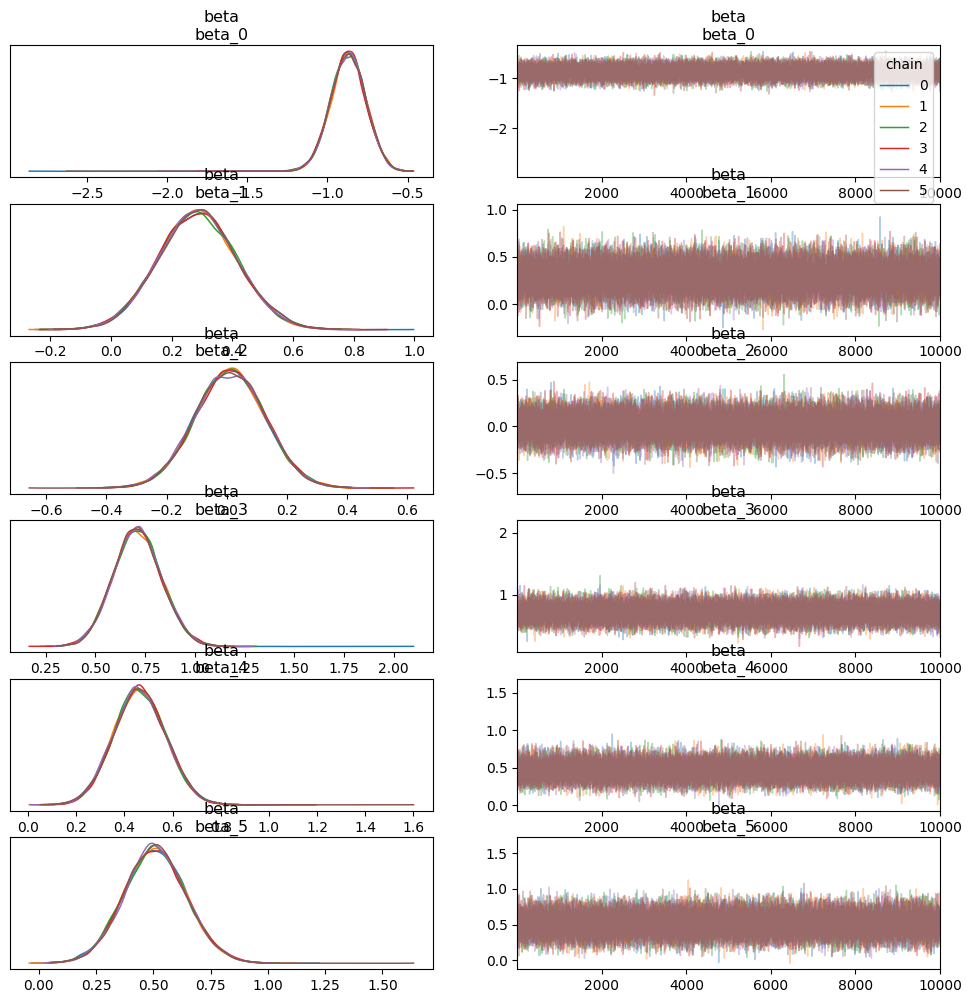

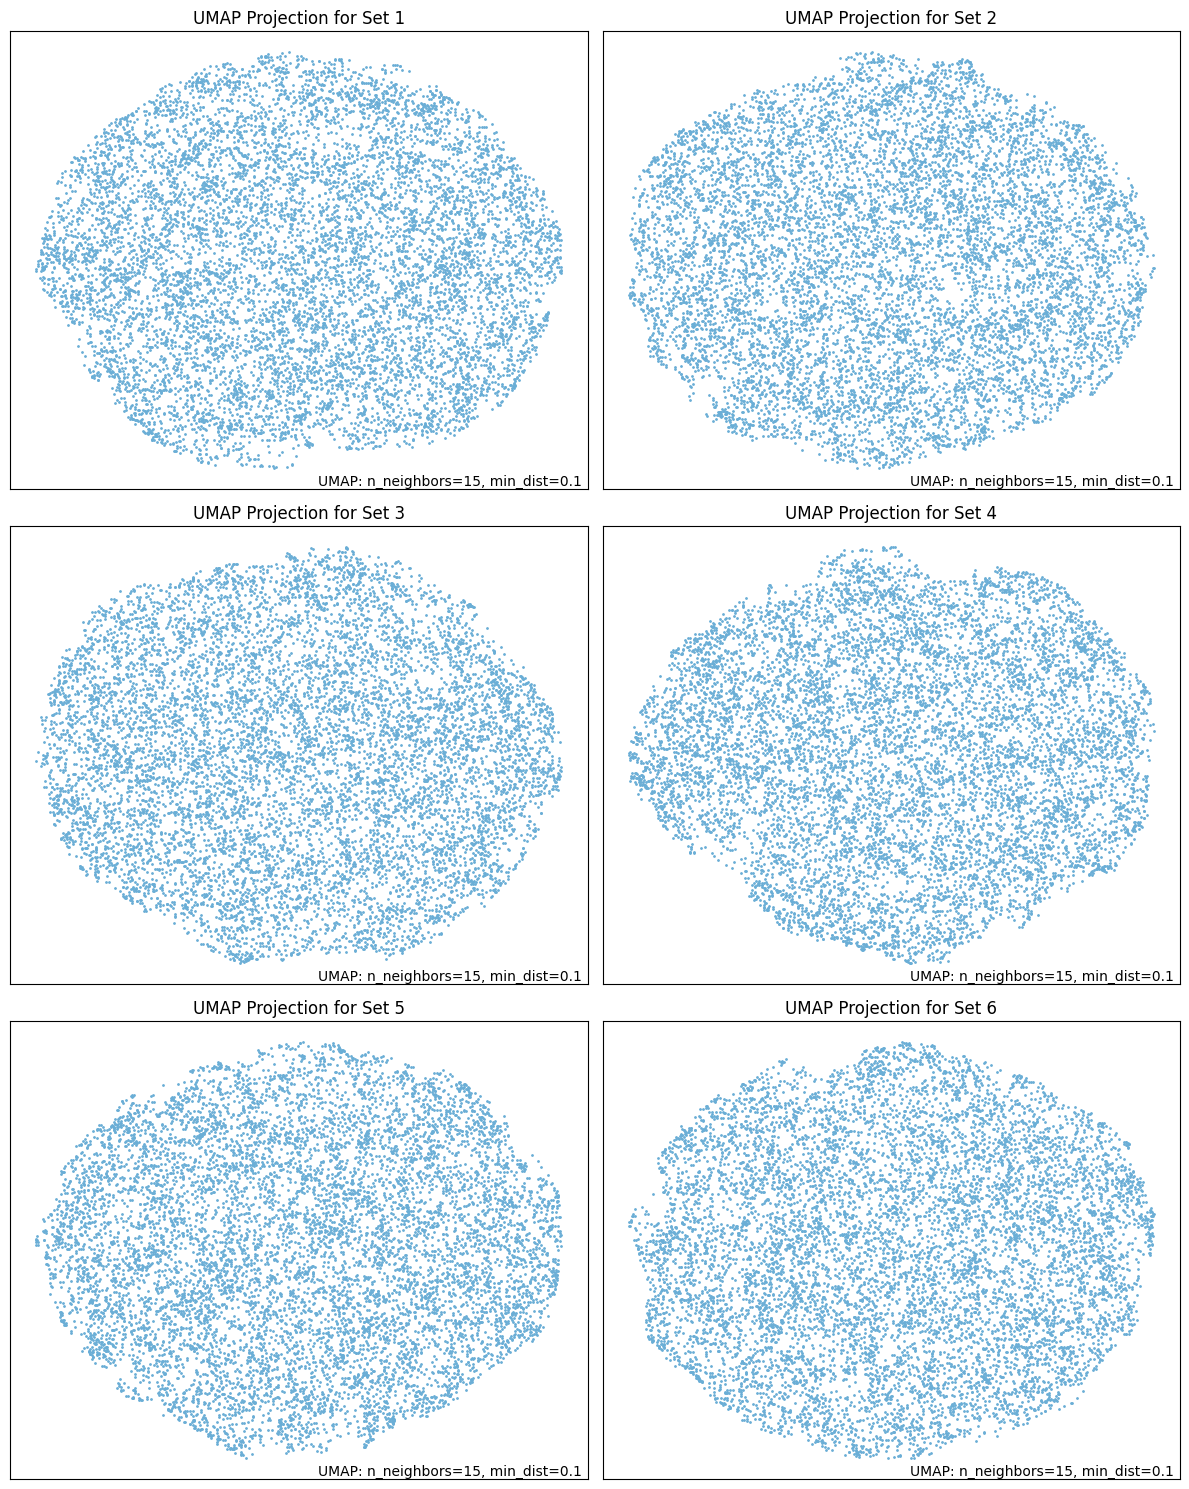

In [5]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
import umap.plot

# trace plot of PG
PG_data_dict = {"beta": beta_PG}
betadata_PG = az.convert_to_dataset(PG_data_dict,
                                    coords=coords, dims=dims)
az.plot_trace(betadata_PG, combined=False, compact=False, legend=True)

# Create a 3x2 grid for UMAP plots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Apply UMAP and plot in subplots without a loop for plotting
for r in range(6):
    betadata_PG_r = az.convert_to_dataset(beta_PG[r].T)
    df = pd.DataFrame(beta_PG[r], columns=['beta0', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5'])
    
    # Fit UMAP
    map = UMAP().fit(df)

    # Determine the correct subplot position
    ax = axes[r // 2, r % 2]
    
    # Use plot.points to plot directly to the subplot
    umap.plot.points(map, ax=ax)  # Assign UMAP points to the specific subplot
    ax.set_title(f'UMAP Projection for Set {r + 1}')

# Adjust layout
plt.tight_layout()
plt.show()

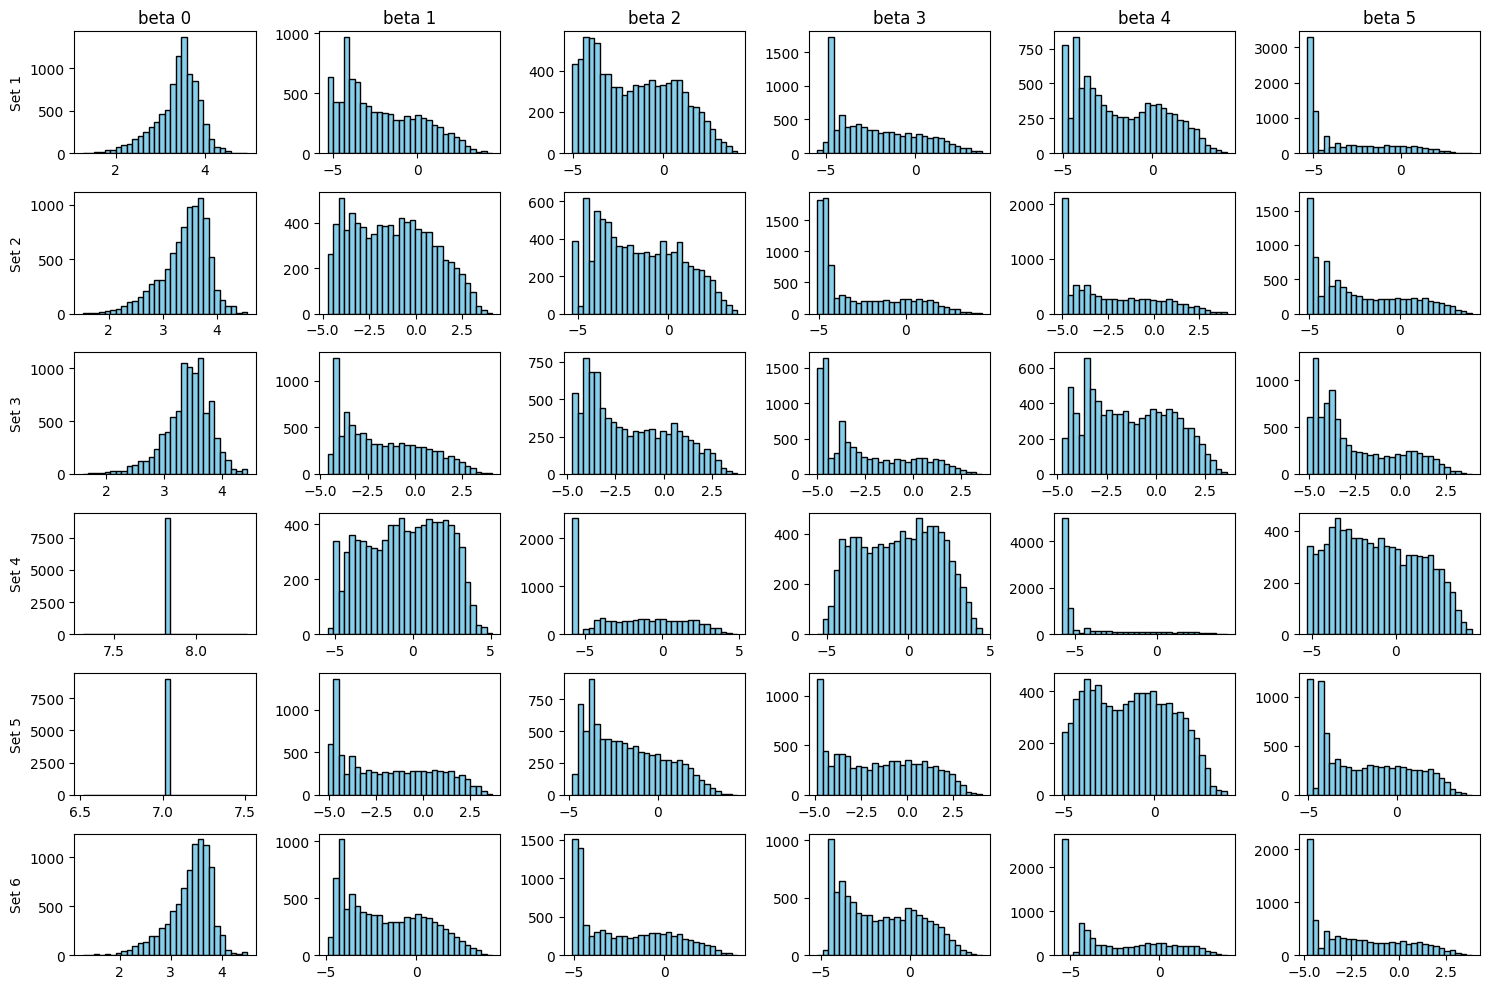

In [6]:

import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 6, figsize=(15, 10))

# Plot histogram for each parameter
for i in range(6):
    for j in range(6):
        ax = axes[i, j]
        
        # Plot histogram for the parameter in the current set
        ax.hist(beta_MH[i, :, j][1000:], bins=30, color='skyblue', edgecolor='black')
        
        # Set titles for clarity
        if i == 0:
            ax.set_title(f'beta {j}')
        if j == 0:
            ax.set_ylabel(f'Set {i + 1}')

plt.tight_layout()
plt.show()

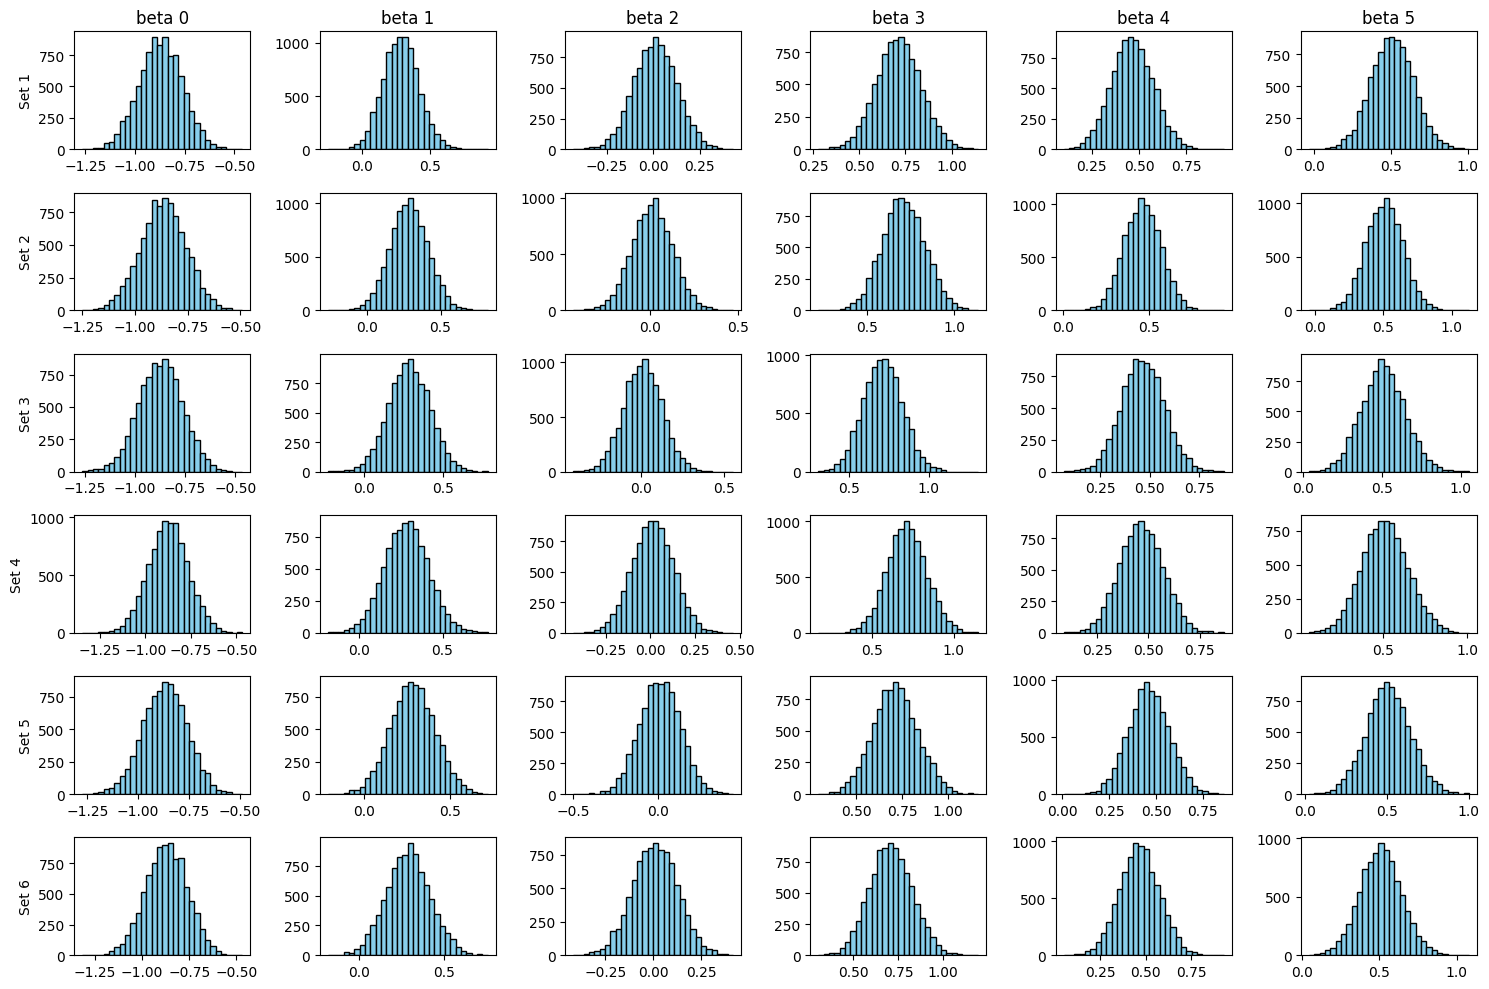

In [7]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 6, figsize=(15, 10))

# Plot histogram for each parameter
for i in range(6):
    for j in range(6):
        ax = axes[i, j]
        
        # Plot histogram for the parameter in the current set
        ax.hist(beta_PG[i, :, j][1000:], bins=30, color='skyblue', edgecolor='black')
        
        # Set titles for clarity
        if i == 0:
            ax.set_title(f'beta {j}')
        if j == 0:
            ax.set_ylabel(f'Set {i + 1}')

plt.tight_layout()
plt.show()

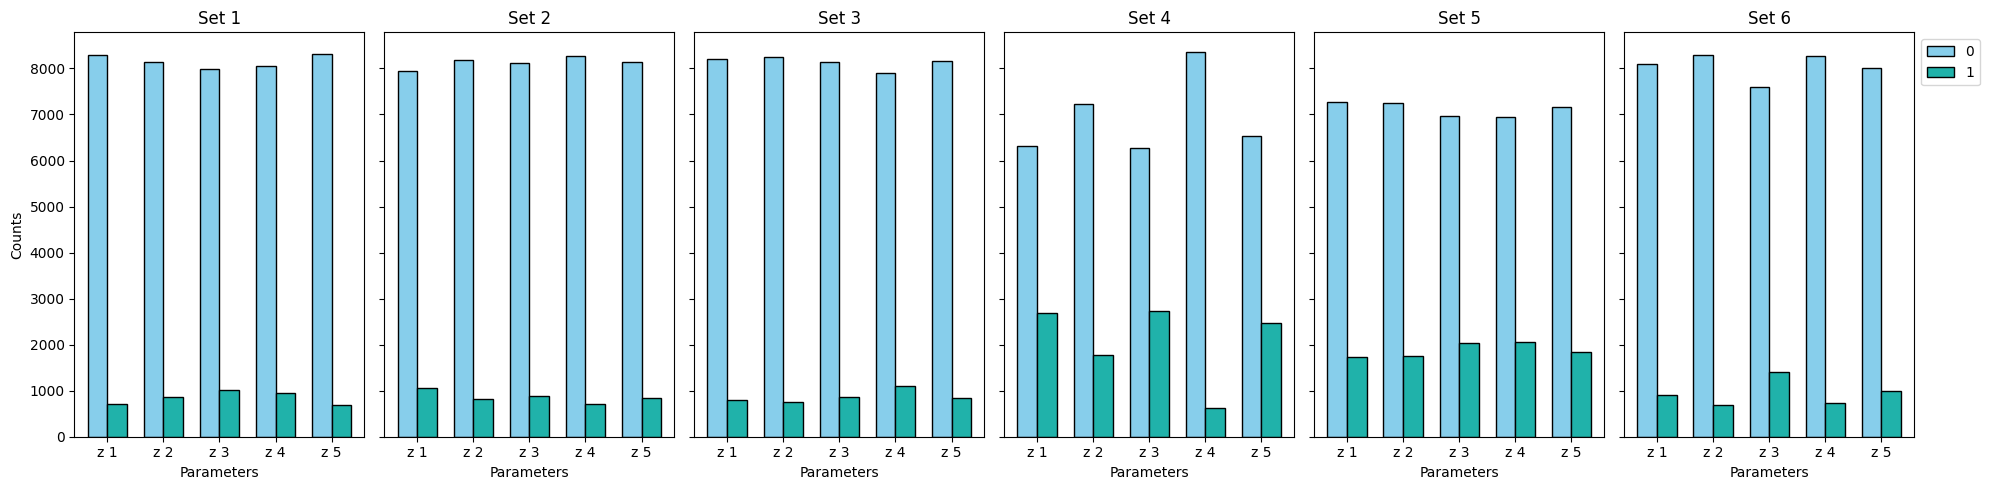

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Set up a grid for the bar plots, with one row for each set
fig, axes = plt.subplots(1, 6, figsize=(20, 5), sharey=True)  # 1 row, 6 columns for each set

for i in range(6):  # Loop over each set
    ax = axes[i]
    
    # Collect counts for each parameter within the set
    counts_zeros = [np.sum(z_MH[i, :, j][1000:] == 0) for j in range(1,6)]
    counts_ones = [np.sum(z_MH[i, :, j][1000:] == 1) for j in range(1,6)]
    
    # Define positions for the bars within each set
    x = np.arange(5)  # One position for each parameter in the current set
    width = 0.35      # Width of the bars
    
    # Plot 0's and 1's side-by-side for each parameter in the set
    ax.bar(x - width/2, counts_zeros, width, label='0', color='skyblue', edgecolor='black')
    ax.bar(x + width/2, counts_ones, width, label='1', color='lightseagreen', edgecolor='black')
    
    # Set titles and labels
    ax.set_title(f'Set {i + 1}')
    ax.set_xticks(x)
    ax.set_xticklabels([f'z {j+1}' for j in range(5)])
    ax.set_xlabel("Parameters")
    if i == 0:
        ax.set_ylabel("Counts")

# Add a legend outside the plots for clarity
plt.legend(['0', '1'], loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

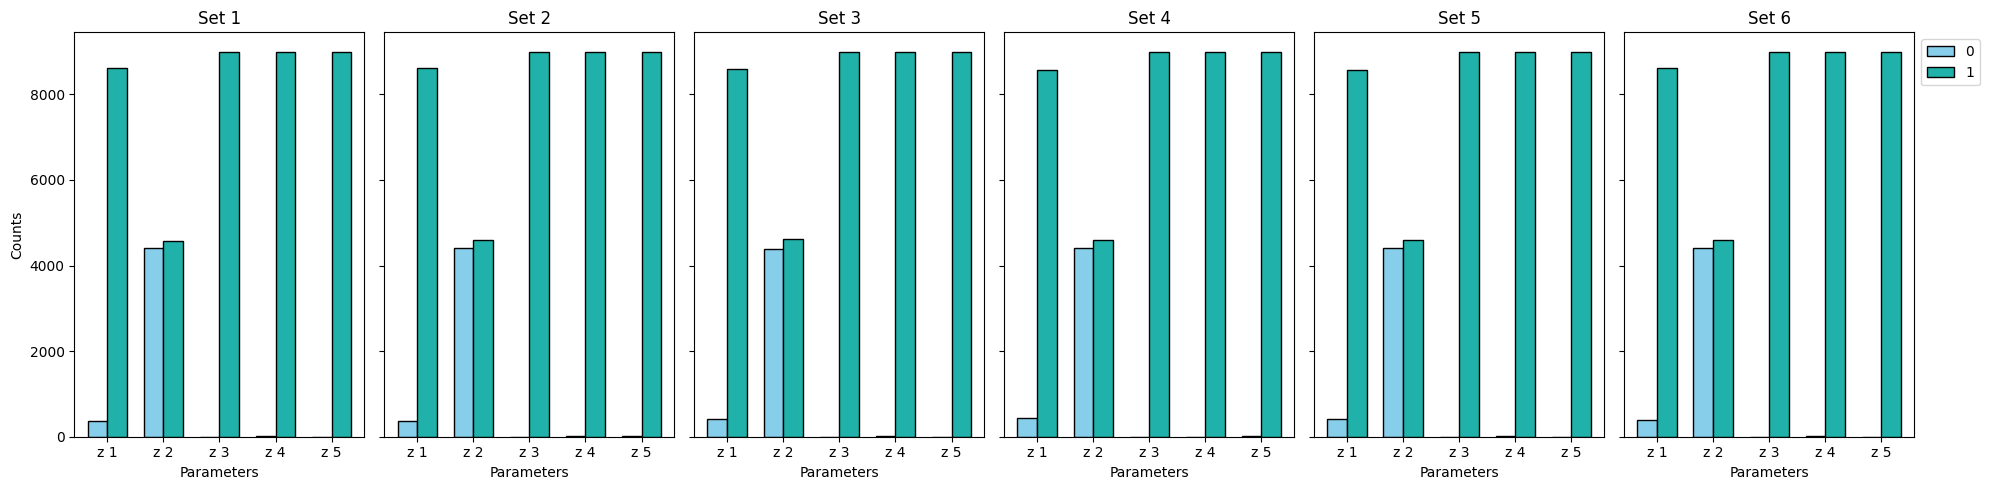

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Set up a grid for the bar plots, with one row for each set
fig, axes = plt.subplots(1, 6, figsize=(20, 5), sharey=True)  # 1 row, 6 columns for each set

for i in range(6):  # Loop over each set
    ax = axes[i]
    
    # Collect counts for each parameter within the set
    counts_zeros = [np.sum(z_PG[i, :, j][1000:] == 0) for j in range(1,6)]
    counts_ones = [np.sum(z_PG[i, :, j][1000:] == 1) for j in range(1,6)]
    
    # Define positions for the bars within each set
    x = np.arange(5)  # One position for each parameter in the current set
    width = 0.35      # Width of the bars
    
    # Plot 0's and 1's side-by-side for each parameter in the set
    ax.bar(x - width/2, counts_zeros, width, label='0', color='skyblue', edgecolor='black')
    ax.bar(x + width/2, counts_ones, width, label='1', color='lightseagreen', edgecolor='black')
    
    # Set titles and labels
    ax.set_title(f'Set {i + 1}')
    ax.set_xticks(x)
    ax.set_xticklabels([f'z {j+1}' for j in range(5)])
    ax.set_xlabel("Parameters")
    if i == 0:
        ax.set_ylabel("Counts")

# Add a legend outside the plots for clarity
plt.legend(['0', '1'], loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

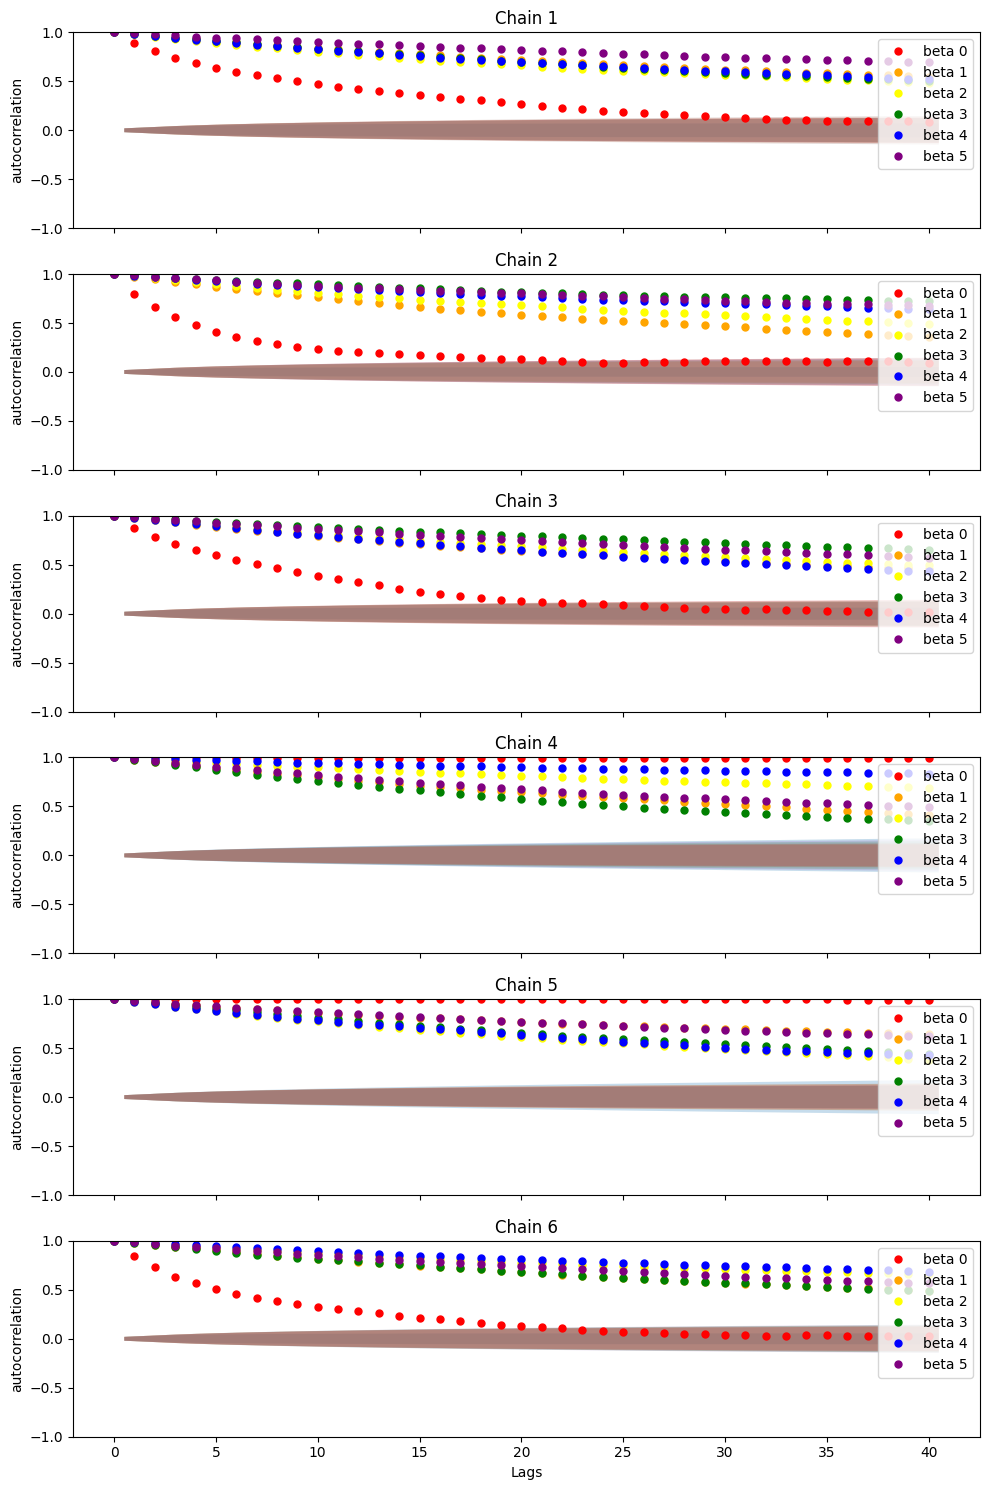

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Set up the ACF matrix plot
fig, axes = plt.subplots(6, 1, figsize=(10, 15), sharex=True)

# Define colors for different dimensions
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

# Iterate through each chain to plot ACF for all dimensions
for i in range(6):
    ax = axes[i]
    
    for j in range(6):
        # Plot ACF for the current dimension
        plot_acf(beta_MH[i, :, j], ax=ax, color=colors[j],
                 use_vlines=False, label=f'beta {j}')

    ax.set_title(f'Chain {i + 1}')
    ax.set_ylabel('autocorrelation')
    ax.legend(loc='upper right')

plt.xlabel('Lags')
plt.tight_layout()
plt.show()

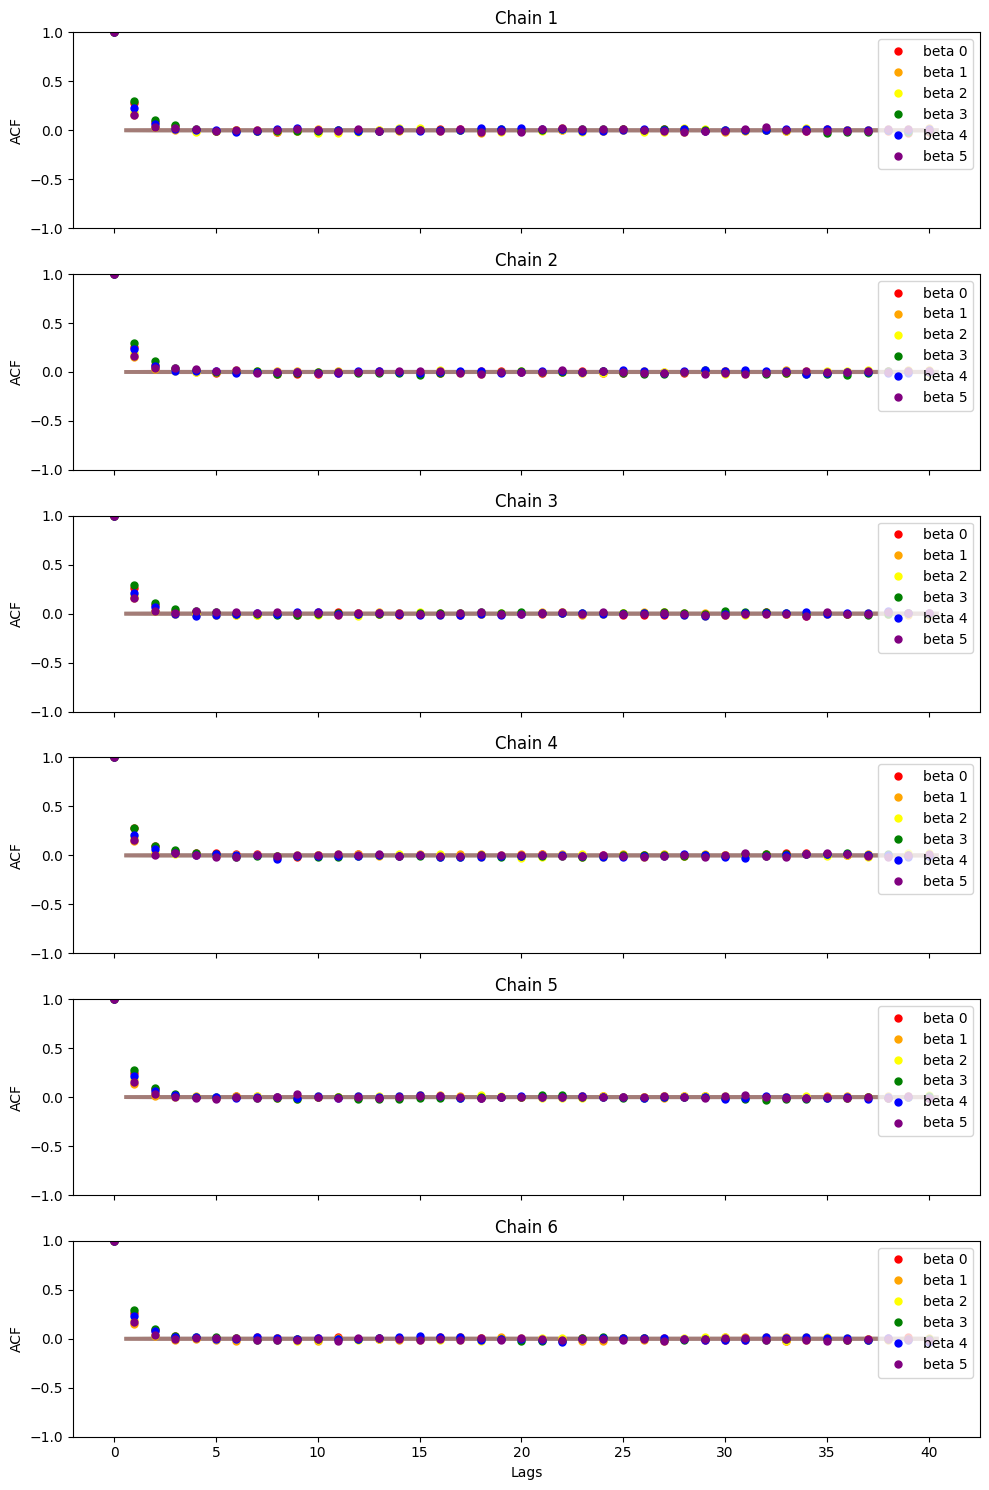

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Set up the ACF matrix plot
fig, axes = plt.subplots(6, 1, figsize=(10, 15), sharex=True)

# Define colors for different dimensions
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

# Iterate through each chain to plot ACF for all dimensions
for i in range(6):
    ax = axes[i]
    
    for j in range(6):
        # Plot ACF for the current dimension
        plot_acf(beta_PG[i, :, j], ax=ax, color=colors[j],
                 use_vlines=False, label=f'beta {j}')

    ax.set_title(f'Chain {i + 1}')
    ax.set_ylabel('ACF')
    ax.legend(loc='upper right')

plt.xlabel('Lags')
plt.tight_layout()
plt.show()

In [13]:
beta_MH_3, z_MH_3 = MetropolisHastingsSampler(y, X, z[0], beta[0], mean_beta, cov_beta, 30000).run_sampler()

/Users/cherylshi/UROP/PoP_venv/lib/python3.11/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


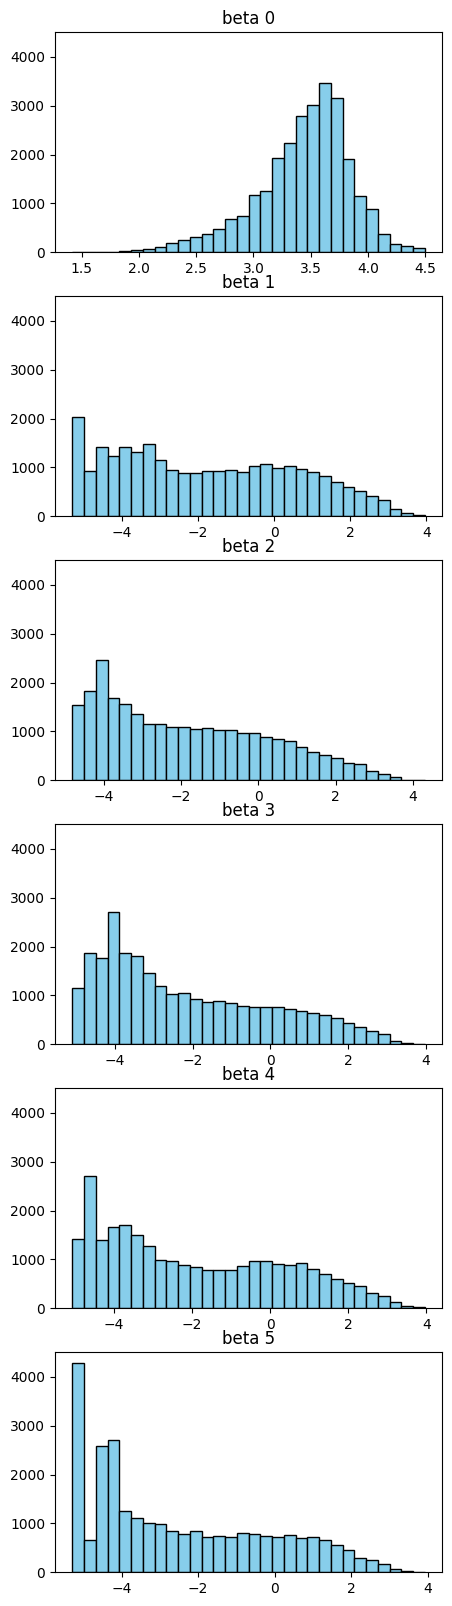

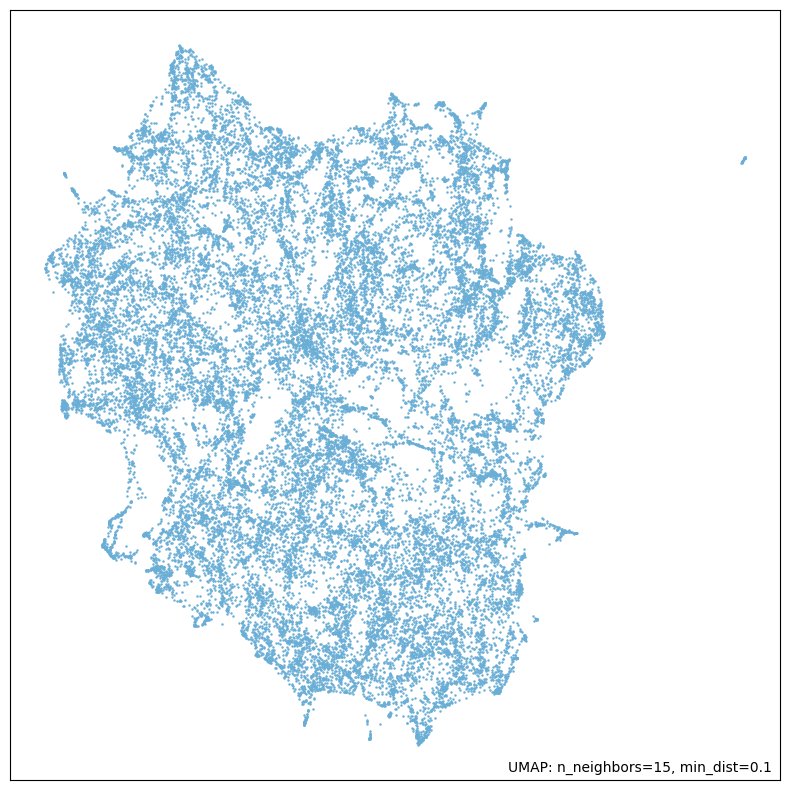

In [42]:
fig, axes = plt.subplots(6, 1, figsize=(5, 20), sharey=True)
for j in range(6):
    ax = axes[j]
    ax.hist(beta_MH_3[:, j][3000:], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'beta {j}')

df = pd.DataFrame(beta_MH_3, columns=['beta0', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5'])

map = UMAP().fit(df)
umap.plot.points(map)

plt.tight_layout()
plt.show()

In [37]:
np.set_printoptions(suppress=True)

ess_MH = np.zeros([6,6], dtype=float)

for i in range(6):
    for j in range(6):
        ess_MH[i, j] = "{:.2f}".format(az.ess(beta_MH[i, :, j]))

ess_MH

array([[  521.36,    36.4 ,    70.11,    21.61,    41.39,     2.97],
       [  364.84,   108.67,    75.52,    11.78,     7.42,    17.16],
       [  370.96,    80.05,    82.39,    18.31,    40.35,    25.89],
       [10000.  ,    89.74,     4.04,    81.16,     1.64,    19.96],
       [10000.  ,     7.76,   105.35,    30.54,    78.97,    11.09],
       [  536.63,    52.48,     3.58,    76.07,     4.09,    33.37]])

In [38]:
ess_PG = np.zeros([6,6])

for i in range(6):
    for j in range(6):
        ess_PG[i, j] = "{:.2f}".format(az.ess(beta_PG[i, :, j]))

print(ess_PG)

[[5487.96 7209.6  6750.23 5172.68 6256.58 6848.06]
 [5882.13 7091.59 6716.34 5098.19 6076.15 6291.52]
 [5600.58 7258.51 6959.24 5016.01 6490.26 6350.67]
 [5076.62 7240.93 6664.75 5167.1  6056.17 7397.12]
 [5917.75 7504.23 6895.44 5459.42 6179.59 7306.7 ]
 [5478.15 7403.66 6509.25 5199.45 5583.46 6974.59]]


In [50]:
ess_3 = np.array([az.ess(beta_MH_3[:,j]) for j in range(6)])
print(ess_3)

[906.13033292  24.91492773 174.02102457  97.02557981  10.6052767
  16.8168172 ]
